<h1>Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Data-preparation" data-toc-modified-id="Data-preparation-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Data preparation</a></span></li><li><span><a href="#Model-training-and-validation-for-each-region" data-toc-modified-id="Model-training-and-validation-for-each-region-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Model training and validation for each region</a></span></li><li><span><a href="#Preparation-for-profit-calculation" data-toc-modified-id="Preparation-for-profit-calculation-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Preparation for profit calculation</a></span></li><li><span><a href="#Function-for-profit-calculation" data-toc-modified-id="Function-for-profit-calculation-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Function for profit calculation</a></span></li><li><span><a href="#Calculation-of-risks-and-profits-for-each-region" data-toc-modified-id="Calculation-of-risks-and-profits-for-each-region-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Calculation of risks and profits for each region</a></span></li></ul></div>

# Project description: Choosing a location for the well

We work for an oil extraction company. We need to decide where to drill a new well.

The steps for choosing a location are usually as follows:
- In the chosen region, they collect characteristics for the wells: the quality of oil and the volume of its reserves;
- They build a model to predict the amount of reserves in new wells;
- Select the wells with the highest value estimates;
- Identify the region with the maximum total revenue of the selected wells.

We are provided with oil samples from three regions. The characteristics for each well in the region are already known. We need to build a model to determine the region where production will bring the highest profit. We will analyze the possible profits and risks using the Bootstrap technique.

**Data description**.

- id - unique identifier of the well;
- f0, f1, f2 - three features of the well ( it doesn't matter what they mean, but the features themselves are meaningful)
- product - volume of reserves in the well (thousand barrels).

**Task conditions:**.
- Only linear regression is suitable for model training (the others are not sufficiently predictable).
- When exploring the region 500 points are examined, from which 200 best locations are selected for development using machine learning.
- The budget for well development in the region is 10 billion roubles.
- At current prices, one barrel of raw materials yields 450 roubles in revenue. The income from each unit is RUB 450 thousand, as the volume is given in thousands of barrels.
- After assessing the risks, it is necessary to leave only those regions where the probability of loss is less than 2.5%. Among them, the region with the highest average profit is chosen.

## Data preparation

In [1]:
# Import the required libraries 

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from numpy.random import RandomState

from sklearn.linear_model import LinearRegression

from sklearn.metrics import mean_squared_error

import warnings
warnings.filterwarnings('ignore')

In [2]:
try:
    df_1 = pd.read_csv('geo_data_0.csv')
    df_2 = pd.read_csv('geo_data_1.csv')
    df_3 = pd.read_csv('geo_data_2.csv')
    
except FileNotFoundError:
    df_1 = pd.read_csv('/datasets/geo_data_0.csv')
    df_2 = pd.read_csv('/datasets/geo_data_1.csv')
    df_3 = pd.read_csv('/datasets/geo_data_2.csv')
    

**Overview the data for Region 1**

In [3]:
display(df_1.info(), df_1.sample(5), df_1.describe(include='all'))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


None

,id,f0,f1,f2,product
13513,Kz67F,0.797503,0.770247,0.982367,70.190560
88617,pqLTf,-1.061050,0.193819,3.160022,3.484813
64986,6Jn7c,2.006508,0.060402,11.190830,166.701080
38543,uLYmz,1.954147,0.049373,-3.193165,107.126523
14571,8NEUC,0.680485,0.801410,-2.447211,11.996170


,id,f0,f1,f2,product
count,100000,100000.000000,100000.000000,100000.000000,100000.000000
unique,99990,NaN,NaN,NaN,NaN
top,fiKDv,NaN,NaN,NaN,NaN
freq,2,NaN,NaN,NaN,NaN
mean,NaN,0.500419,0.250143,2.502647,92.500000
std,NaN,0.871832,0.504433,3.248248,44.288691
min,NaN,-1.408605,-0.848218,-12.088328,0.000000
25%,NaN,-0.072580,-0.200881,0.287748,56.497507
50%,NaN,0.502360,0.250252,2.515969,91.849972
75%,NaN,1.073581,0.700646,4.715088,128.564089


In [4]:
# checking the explicit duplicates

df_1.duplicated().sum()

0

**Overview the data for Region 2**

In [5]:
display(df_2.info(), df_2.sample(5), df_2.describe(include='all'))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


None

,id,f0,f1,f2,product
33735,Ea8Nq,6.415251,-13.261488,4.999507,134.766305
63366,EgIYZ,7.244431,-10.096017,4.989528,134.766305
74068,yIHvx,10.826572,2.420038,-0.005032,0.000000
81976,8iiKX,17.040045,-6.108416,4.003120,107.813044
80773,YeLM2,12.953036,0.542463,3.002770,80.859783


,id,f0,f1,f2,product
count,100000,100000.000000,100000.000000,100000.000000,100000.000000
unique,99996,NaN,NaN,NaN,NaN
top,wt4Uk,NaN,NaN,NaN,NaN
freq,2,NaN,NaN,NaN,NaN
mean,NaN,1.141296,-4.796579,2.494541,68.825000
std,NaN,8.965932,5.119872,1.703572,45.944423
min,NaN,-31.609576,-26.358598,-0.018144,0.000000
25%,NaN,-6.298551,-8.267985,1.000021,26.953261
50%,NaN,1.153055,-4.813172,2.011479,57.085625
75%,NaN,8.621015,-1.332816,3.999904,107.813044


In [6]:
# checking the explicit duplicates

df_2.duplicated().sum()

0

**Overview the data for Region 3**

In [7]:
display(df_3.info(), df_3.sample(5), df_3.describe(include='all'))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


None

,id,f0,f1,f2,product
3806,D8vPp,-1.512211,-0.774684,-1.045065,40.115669
19050,7ZAda,0.800544,-0.775542,4.107835,101.637456
66295,5IszV,-0.724906,1.752046,-3.139625,55.276411
70099,63TKU,3.825073,3.715895,-0.862341,96.688915
63506,0qUAG,-0.339259,-2.249991,2.018782,79.585288


,id,f0,f1,f2,product
count,100000,100000.000000,100000.000000,100000.000000,100000.000000
unique,99996,NaN,NaN,NaN,NaN
top,VF7Jo,NaN,NaN,NaN,NaN
freq,2,NaN,NaN,NaN,NaN
mean,NaN,0.002023,-0.002081,2.495128,95.000000
std,NaN,1.732045,1.730417,3.473445,44.749921
min,NaN,-8.760004,-7.084020,-11.970335,0.000000
25%,NaN,-1.162288,-1.174820,0.130359,59.450441
50%,NaN,0.009424,-0.009482,2.484236,94.925613
75%,NaN,1.158535,1.163678,4.858794,130.595027


In [8]:
# checking the explicit duplicates

df_3.duplicated().sum()

0

**Conclusion:**

- there are 100,000 objects in the datasets for each of the three regions. There are no missing values and there are no problems with the data types either.
- the overall statistics for the three well attributes (`f0`, `f1`, `f2`) are uninformative, as there is no exact understanding of which object parameters are contained in these columns.
- no explicit duplicates were found in any dataset. 
- In each dataset, there is a meager number of duplicate values in the `id` column: 10 duplicates in Region 1 and 4 duplicates in Regions 2 and 3 each. This may be an indication that some of the wells had multiple parameter measurements.
- For the purpose of building machine learning models, the `id' column is irrelevant and will be removed from each dataset when the model is built.

Let's analyse the correlation between the features in each dataset.

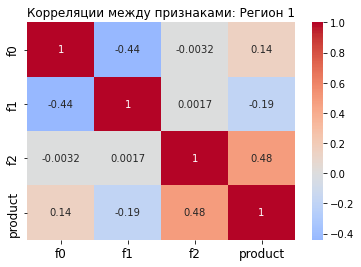

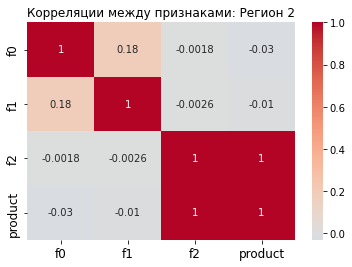

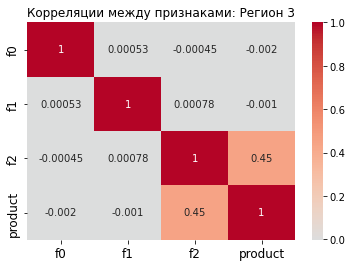

In [9]:
plt.figure()
sns.heatmap(df_1.corr(), xticklabels=df_1.corr().columns, yticklabels=df_1.corr().columns, cmap='coolwarm', center=0, annot=True)
plt.title('Корреляции между признаками: Регион 1', fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

plt.figure()
sns.heatmap(df_2.corr(), xticklabels=df_2.corr().columns, yticklabels=df_2.corr().columns, cmap='coolwarm', center=0, annot=True)
plt.title('Корреляции между признаками: Регион 2', fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

plt.figure()
sns.heatmap(df_3.corr(), xticklabels=df_3.corr().columns, yticklabels=df_3.corr().columns, cmap='coolwarm', center=0, annot=True)
plt.title('Корреляции между признаками: Регион 3', fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

In the dataset for Region 1, there is an average negative correlation (-0.44) between features `f0` and `f1`, and an average positive correlation (0.48) between feature `f2` and the target feature.

In the dataset for Region 2, there is an absolute positive correlation (1) between the feature `f2` and the target feature. We can assume that the ML model will detect this correlation and will easily predict the target feature, demonstrating high quality.

In the dataset for Region 3, there is a medium positive correlation (0.45) between the feature `f2` and the target feature.

## Model training and validation for each region

Given that the process of preparing data for training and model validation is the same for all three datasets, it makes sense to automate the process by writing a function. 

In [10]:
def modelling(df):
    
    # defining features and target 
    features = df.drop(['id', 'product'], axis=1)
    target = df['product']
    
    # splitting the data into training and validation sets in proportion of 75:25 
    features_train, features_valid, target_train, target_valid = train_test_split(features, target, random_state=12345, test_size=0.25)
    
    # scaling numeric features by defining the scaler object and fitting it on train data
    numeric = ['f0', 'f1', 'f2']
    scaler = StandardScaler()
    scaler.fit(features_train[numeric])
    
    # transforming training & validation datasets by means of transform() function
    features_train[numeric] = scaler.transform(features_train[numeric])
    features_valid[numeric] = scaler.transform(features_valid[numeric])
    
    # initializing, fitting and getting predictions of Linear Regression model
    lg = LinearRegression(n_jobs=-1)
    lg.fit(features_train, target_train)
    predictions_valid = pd.Series(lg.predict(features_valid), index=target_valid.index)
    
    return predictions_valid, target_valid
    

Will save the model predictions and the true values on the validation sample for each region in the appropriate variables.

In [11]:
df_1_pred, df_1_target_valid = modelling(df_1)
df_2_pred, df_2_target_valid = modelling(df_2)
df_3_pred, df_3_target_valid = modelling(df_3)

Let's calculate for each region the mean value of raw material stock predicted by the model, as well as the quality metric of the model - Root Mean Square Error (RMSE) metric. We will present the results of the calculations in the table.

In [12]:
pd.DataFrame({'Регион 1':[df_1_pred.mean(),mean_squared_error(df_1_target_valid, df_1_pred)**0.5], 
              'Регион 2': [df_2_pred.mean(),mean_squared_error(df_2_target_valid, df_2_pred)**0.5], 
              'Регион 3':[df_3_pred.mean(), mean_squared_error(df_3_target_valid, df_3_pred)**0.5]}, 
              index=['Средний запас предсказанного сырья, тыс. баррелей','RMSE модели'])

,Регион 1,Регион 2,Регион 3
"Средний запас предсказанного сырья, тыс. баррелей",92.592568,68.728547,94.965046
RMSE модели,37.579422,0.893099,40.029709


The calculation results show a roughly comparable picture for regions 1 and 3, in terms of average predicted crude stock (92.6t and 95t barrels, respectively). However, the error value for both models is also extremely high, indicating that the risk of profit shortfalls due to erroneous predictions is very high.

Region 2 has a lower average stock of predicted production, but the error is very low, which is also a very questionable fact (the model predicts with almost 100% accuracy). Let us look at the distribution of the target feature for Region 2. 

In [13]:
df_2['product'].value_counts()

53.906522     8472
26.953261     8468
84.038886     8431
57.085625     8390
3.179103      8337
80.859783     8320
30.132364     8306
134.766305    8304
110.992147    8303
0.000000      8235
137.945408    8233
107.813044    8201
Name: product, dtype: int64

In [14]:
display(df_1['product'].nunique(), df_2['product'].nunique(), df_3['product'].nunique())

100000

12

100000

This low RMSE value is now more understandable. After all, there are only 12 unique values out of 100000 in the target feature, which gives the model almost 100% predictive accuracy. 

## Preparation for profit calculation

According to the condition of the task, the best 200 wells are selected for development out of 500 wells under study, based on the model's prediction. 

The total budget for the development of 200 wells is 10 billion roubles.

The price per barrel = RUB 450. Since the volume of wells' reserves is given in thousands of barrels, the unit cost (i.e., thousands of barrels) is 450000 roubles.

Thus, the calculation of the break-even point consists in determining the minimum required volume of raw materials in the well, at which the income from its development will cover the costs of its development. 

In [15]:
# Input parameters

total_well = 500 # total number of wells explored in the region
well_num = 200 # the number of potentially most profitable wells selected by the ML model for development  
total_budget = 10000000000 # total budget for developing 200 wells in the region
price_per_product = 450000 # cost of a thousand of barrels (stocks are also shown in thousands of barrels)

In [16]:
# Calculating the budget for developing one well

budget_per_well = total_budget / well_num
print('Стоимость разработки одной скважины, руб.:', budget_per_well)

Стоимость разработки одной скважины, руб.: 50000000.0


In [17]:
# Calculate the break-even point = the minimum amount of raw material in the well required to cover its development costs

min_product_volume = budget_per_well / price_per_product
print('Минимальный объём сырья для безубыточной разработки новой скважины, тыч. баррелей:', min_product_volume)

Минимальный объём сырья для безубыточной разработки новой скважины, тыч. баррелей: 111.11111111111111


**Conclusion:**

For a well to break even, it must have a reserve of at least 111,000 barrels. Otherwise, the investment in well development will not pay off.

The average model predictions for each of the three regions indicate a lower average feedstock in the well than is needed to break-even. In this case, the average stock in the well does not allow a definitive conclusion about the selection of the most profitable region. 

**It is necessary to select the potentially most profitable wells where the predicted feedstock will be higher than the break-even point.

## Function for profit calculation

Let's write a function to calculate the profit from the selected wells and model predictions. To do this:
1. let's select the wells with maximum values of model predictions. According to the conditions of the task, 200 wells with the highest predicted feedstock are selected.
2. Let's sum up the target value of raw material volume corresponding to these predictions.
3. Let's calculate the profit for the obtained volume of raw materials. We calculate the profit as the difference between revenue and investment in well development.

In [18]:
# function to calculate profits from selected wells and model predictions.

def revenue(target, probabilities, count):
    probs_sorted = probabilities.sort_values(ascending=False)
    selected = target[probs_sorted.index][:count]
    return round((price_per_product * selected.sum() - total_budget)/1000000000,2)

In [19]:
print(f'Общая прибыль по Региону 1: {revenue(df_1_target_valid, df_1_pred, well_num)} млрд. рублей')
print(f'Общая прибыль по Региону 2: {revenue(df_2_target_valid, df_2_pred, well_num)} млрд. рублей')
print(f'Общая прибыль по Региону 3: {revenue(df_3_target_valid, df_3_pred, well_num)} млрд. рублей')

Общая прибыль по Региону 1: 3.32 млрд. рублей
Общая прибыль по Региону 2: 2.42 млрд. рублей
Общая прибыль по Региону 3: 2.71 млрд. рублей


The calculations show that the highest profit from the calculation of the top 200 wells in terms of raw material reserves predicted by the model is observed in Region 1 = 3.32 billion roubles. Based on these calculations, we can assume that Region 1 is our choice for well development.

## Calculation of risks and profits for each region

Let's calculate the risks and profits for each region. To do this:
1. Will apply the Bootstrap technique with 1000 samples to find the profit distribution.
2. Will find the average profit, the 95% confidence interval and the risk of loss. We will consider a negative profit to be a loss.

In [20]:
# function to calculate profits and risks using Bootstrap technique with 1000 samples

state = np.random.RandomState(12345)

def revenue_risk_calc(target, probabilities):
    
    profit = [] # creating a list to consolidate the profit values calculated for each of the 1000 samples
    
    for i in range(1000):
        target_subsample = target.sample(n=total_well, random_state=state, replace=True)
        probs_subsample = probabilities[target_subsample.index]
        
        profit.append(revenue(target_subsample, probs_subsample, well_num))
        
    profit = pd.Series(profit)
    mean_profit = profit.mean() # calculating average profit
    confidence_interval = (profit.quantile(0.025), profit.quantile(0.975)) # Calculating a 95% confidence interval, eliminating 2.5% from the bottom and top 
    risk = (profit<0).mean() # calculating the risk of loss (profit value less than 0)
    
    print(f'\tСредняя прибыль: {mean_profit:.3f} млрд. рублей')
    print(f'\t95%-й доверительный интервал: {confidence_interval} млрд. рублей')
    print(f'\tРиск убытков: {risk:.2%}')
    

Let us calculate the average profit, the 95% confidence interval and the risk of loss separately for each of the regions.

In [21]:
print('Регион 1:')
revenue_risk_calc(df_1_target_valid, df_1_pred)

print('\nРегион 2:')
revenue_risk_calc(df_2_target_valid, df_2_pred)

print('\nРегион 3:')
revenue_risk_calc(df_3_target_valid, df_3_pred)

Регион 1:
	Средняя прибыль: 0.426 млрд. рублей
	95%-й доверительный интервал: (-0.1, 0.95) млрд. рублей
	Риск убытков: 5.90%

Регион 2:
	Средняя прибыль: 0.518 млрд. рублей
	95%-й доверительный интервал: (0.13, 0.9502499999999997) млрд. рублей
	Риск убытков: 0.20%

Регион 3:
	Средняя прибыль: 0.420 млрд. рублей
	95%-й доверительный интервал: (-0.12, 0.99) млрд. рублей
	Риск убытков: 5.80%


**Conclusion:**

As a result of applying Bootstrap technique (extracting from a total sample the 1000 subsamples of 500 wells per region), our calculations show that the only eligible region (probability of loss less than 2.5%) is Region 2, where all KPIs performed the best.

In this region, we observe the following indicators:

- The risk of loss is only 0.2%, which is a very low figure, indicating that investment in the development of this region is practically risk-free;
- The average profit is 518 million roubles;
- 95% confidence interval (RUB 130 - 950 million) is the narrowest among all regions and does not contain negative values.